In [1]:
from hdbcli import dbapi
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import plotly.express as px

from functools import reduce

from datetime import datetime
import datetime

pd.set_option('display.max_columns', None)

load_dotenv()

False

In [2]:
serverAdress_prod='vp55db01.sce.com' 
serverPort_prod=30015 
userName_prod = 'linz'
passWord_prod = 'Wojiazainingbo@1968'
#userName_prod=os.getenv('USER') 
#passWord_prod=os.getenv('PASSWORD') 

# Connect to hana database
try:
    cnn = dbapi.connect(serverAdress_prod,serverPort_prod,userName_prod,passWord_prod) 
    print('SAP connection established')
    cursor_prod=cnn.cursor() 
except Exception as e:
    print(f'ERROR: {e}')

SAP connection established


In [3]:
import vertexai
from snowflake.snowpark import Session
from snowflake.connector.pandas_tools import write_pandas

from google.cloud import secretmanager
from google.cloud import aiplatform
from google.cloud import storage
import json
import time

def access_secret_version(project_id, secret_id, version_id="latest"):
    client = secretmanager.SecretManagerServiceClient()
    name = f"projects/{project_id}/secrets/{secret_id}/versions/{version_id}"

    response = client.access_secret_version(request={"name": name})
    payload = response.payload.data.decode("UTF-8")
    return payload

In [4]:
# !pip install snowflake
# !pip install snowflake-snowpark-python
# !pip install google-cloud-secret-manager

In [5]:
path_name='gs://ebill_model'
from datetime import date

cutoff_date=date.today()
print(cutoff_date)

2025-11-12


In [6]:
projectID="sceg-p-prj-dxg-007"
us_site="us-west1"

### Part 5 - Model performance monitoring
* The following code is to be run posterior to the cut-off date.  We need to give a window of a few days to collect enrollment results.
* For monitoring model performance, make sure to change the cut-off date to the original date when the list was generated.

In [ ]:
##deploy_file=pd.read_csv(str(path_name)+str('/deploy_file_')+formatted_date+str('.csv'))
resi_file=pd.read_csv(str(path_name)+str('/deploy_file_resi_')+str(formatted_date)+str('.csv'))
nonresi_file=pd.read_csv(str(path_name)+str('/deploy_file_nonresi_')+str(formatted_date)+str('.csv'))

deploy_file=pd.concat([resi_file.assign(seg='resi'), nonresi_file.assign(seg='nonresi')])
deploy_file.groupby('seg').size()

In [9]:
resi_file=pd.read_csv(str(path_name)+str('/deploy_file_resi_')+'20251105'+str('.csv'))
nonresi_file=pd.read_csv(str(path_name)+str('/deploy_file_nonresi_')+'20251105'+str('.csv'))

deploy_file=pd.concat([resi_file.assign(seg='resi'), nonresi_file.assign(seg='nonresi')])
deploy_file.groupby('seg').size()

seg
nonresi    200806
resi       877270
dtype: int64

In [10]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-11-05';

    SELECT 
            ZOBJTID as cact,
            max(to_date(ZUDATE___T))    as last_enroll_date,
            min(days_between(to_date(ZUDATE___T), cutoff_date)) as last_enroll_recency, 
            sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 365 then 1 else 0 end) as enroll_cnt_lastyear,
            sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 730 then 1 else 0 end) as enroll_cnt_last2years 
        FROM _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR"
            WHERE ZVALUENEW = 'EBIL'
            and to_date(ZUDATE___T) >= cutoff_date
        group by ZOBJTID;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 
    
new_enroll=pd.DataFrame(ret)
new_enroll.columns=['cact', 'past_enroll_date', 'past_enroll_recency', 'enroll_cnt_lastyear', 'enroll_cnt_last2years']
new_enroll.info()
new_enroll.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12135 entries, 0 to 12134
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   cact                   12135 non-null  object
 1   past_enroll_date       12135 non-null  object
 2   past_enroll_recency    12135 non-null  int64 
 3   enroll_cnt_lastyear    12135 non-null  int64 
 4   enroll_cnt_last2years  12135 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 474.1+ KB


,cact,past_enroll_date,past_enroll_recency,enroll_cnt_lastyear,enroll_cnt_last2years
0,600001502597,2025-11-06,-1,2,2
1,600001511085,2025-11-05,0,1,1
2,700001818489,2025-11-05,0,1,1
3,700002838508,2025-11-05,0,1,1
4,700004745566,2025-11-05,0,1,1


In [11]:
new_enroll['cact']=pd.to_numeric(new_enroll['cact'], errors='coerce')
new_enroll.drop_duplicates(subset='cact', keep='first', inplace=True)

In [12]:
# remove possibly erraneous data
print(new_enroll.shape)
new_enroll['past_enroll_dt']=pd.to_datetime(new_enroll['past_enroll_date'], errors='coerce')
new_enroll=new_enroll[new_enroll['past_enroll_dt'] != '2025-10-04']
print(new_enroll.shape)

(12135, 5)
(12135, 6)


In [13]:
pred_file_val=pd.merge(deploy_file, new_enroll.assign(y=1), on='cact', how='left')
pred_file_val['y'].fillna(0, inplace=True)

/var/tmp/ipykernel_7310/2561233026.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pred_file_val['y'].fillna(0, inplace=True)


         seg  score_tier         y
0    nonresi           0  0.047311
1    nonresi           1  0.014940
2    nonresi           2  0.015936
3    nonresi           3  0.016434
4    nonresi           4  0.007968
..       ...         ...       ...
197     resi          96  0.001254
198     resi          97  0.000798
199     resi          98  0.000684
200     resi          99  0.001140
201     resi         100  0.000000

[202 rows x 3 columns]


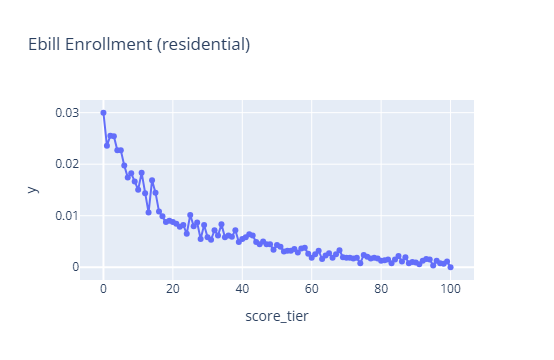

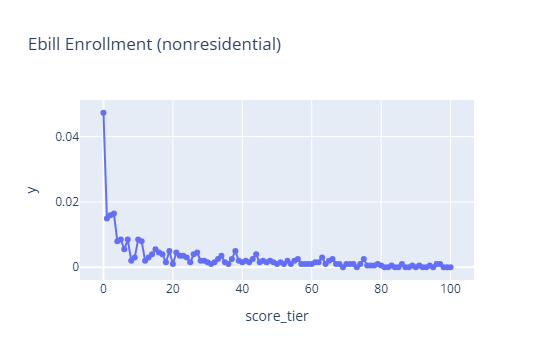

In [14]:
forline=pred_file_val.groupby(['seg', 'score_tier'])['y'].mean().reset_index()
print(forline)
fig = px.line(forline[forline['seg']=='resi'], x='score_tier', y='y', title='Ebill Enrollment (residential)', markers=True)
fig.show()

fig = px.line(forline[forline['seg']=='nonresi'], x='score_tier', y='y', title='Ebill Enrollment (nonresidential)', markers=True)
fig.show()

   Score Bin  % Enrolled  baseline
0         20    0.000838  0.006428
1         19    0.001170  0.006428
2         18    0.001413  0.006428
3         17    0.001277  0.006428
4         16    0.001938  0.006428
5         15    0.001596  0.006428
6         14    0.002462  0.006428
7         13    0.002280  0.006428
8         12    0.003283  0.006428
9         11    0.003557  0.006428
10        10    0.004354  0.006428
11         9    0.005745  0.006428
12         8    0.005996  0.006428
13         7    0.006566  0.006428
14         6    0.008093  0.006428
15         5    0.007956  0.006428
16         4    0.011790  0.006428
17         3    0.014481  0.006428
18         2    0.018980  0.006428
19         1    0.025411  0.006428


/var/tmp/ipykernel_7310/1418057528.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/tmp/ipykernel_7310/1418057528.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



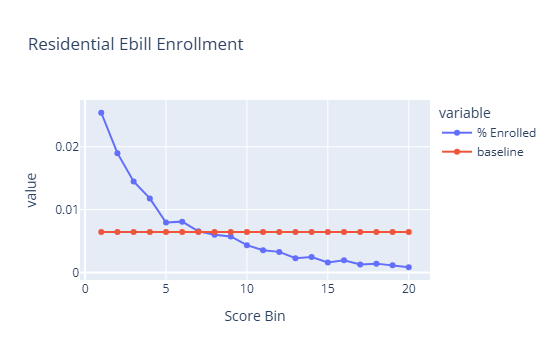

In [16]:
# Divide the score into 20 bins
num_bins=20
labels=list(range(20, 0, -1))
labels

pred_file_val2=pred_file_val[pred_file_val['seg']=='resi']
pred_file_val2['Score Bin']=pd.qcut(pred_file_val2['enroll_score'], q=20, labels=labels)

forline=pred_file_val2.groupby('Score Bin')['y'].mean().reset_index()
forline.rename(columns={'y': '% Enrolled'}, inplace=True)
forline['baseline']=pred_file_val2['y'].mean()
print(forline)
fig = px.line(forline, x='Score Bin', y=['% Enrolled', 'baseline'], title='Residential Ebill Enrollment', 
              markers=True)
fig.show()

   Score Bin  % Enrolled  baseline
0         20    0.000398  0.002898
1         19    0.000199  0.002898
2         18    0.000299  0.002898
3         17    0.000199  0.002898
4         16    0.000996  0.002898
5         15    0.000797  0.002898
6         14    0.001295  0.002898
7         13    0.001593  0.002898
8         12    0.001494  0.002898
9         11    0.001295  0.002898
10        10    0.001693  0.002898
11         9    0.002289  0.002898
12         8    0.002392  0.002898
13         7    0.001992  0.002898
14         6    0.002789  0.002898
15         5    0.003087  0.002898
16         4    0.004084  0.002898
17         3    0.005080  0.002898
18         2    0.005478  0.002898
19         1    0.020516  0.002898


/var/tmp/ipykernel_7310/12943172.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/tmp/ipykernel_7310/12943172.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



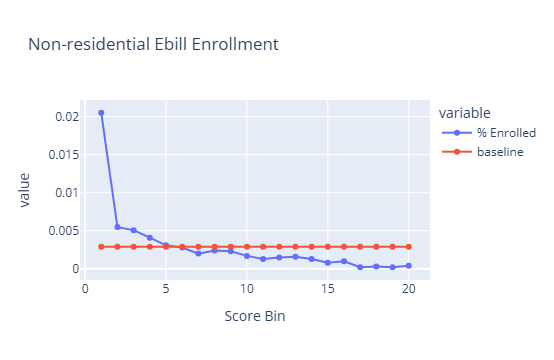

In [17]:
num_bins=20
labels=list(range(20, 0, -1))
labels

pred_file_val2=pred_file_val[pred_file_val['seg']=='nonresi']
pred_file_val2['Score Bin']=pd.qcut(pred_file_val2['enroll_score'], q=20, labels=labels)

forline=pred_file_val2.groupby('Score Bin')['y'].mean().reset_index()
forline.rename(columns={'y': '% Enrolled'}, inplace=True)
forline['baseline']=pred_file_val2['y'].mean()
print(forline)
fig = px.line(forline, x='Score Bin', y=['% Enrolled', 'baseline'], title='Non-residential Ebill Enrollment', 
              markers=True)
fig.show()